In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error

In [2]:
df=pd.read_csv('sample.csv')

# EDA on data, converting into time series data at regular intervals

In [3]:
df.head()

,Invoice Date,Invoice Amount
0,9/4/2019,"$18,464.64"
1,9/19/2019,"$28,139.52"
2,9/23/2019,"$8,655.30"
3,9/27/2019,$288.00
4,10/1/2019,$901.92


In [4]:
df['Time_Stamp'] = pd.to_datetime(df['Invoice Date'])
df['Invoice Amount'] = df['Invoice Amount'].str.replace('$', '').str.replace(',','')

C:\Users\abhay.bhandari\AppData\Local\Temp\ipykernel_304\3191211055.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Invoice Amount'] = df['Invoice Amount'].str.replace('$', '').str.replace(',','')


In [5]:
df['Invoice_Amount'] = df['Invoice Amount']
df.head()

,Invoice Date,Invoice Amount,Time_Stamp,Invoice_Amount
0,9/4/2019,18464.64,2019-09-04,18464.64
1,9/19/2019,28139.52,2019-09-19,28139.52
2,9/23/2019,8655.30,2019-09-23,8655.30
3,9/27/2019,288.00,2019-09-27,288.00
4,10/1/2019,901.92,2019-10-01,901.92


In [6]:
df.drop('Invoice Date',axis=1, inplace=True)
df.drop('Invoice Amount',axis=1, inplace=True)

In [7]:
# Convert 'Invoice Amount' column to numeric
df['Invoice_Amount'] = pd.to_numeric(df['Invoice_Amount'])
df.head()

,Time_Stamp,Invoice_Amount
0,2019-09-04,18464.64
1,2019-09-19,28139.52
2,2019-09-23,8655.30
3,2019-09-27,288.00
4,2019-10-01,901.92


In [8]:
df.set_index('Time_Stamp', inplace=True)

# Resample data to weekly intervals
df_ten = df.resample('10D').sum()
df_ten.head()

,Invoice_Amount
Time_Stamp,
2019-09-04,18464.64
2019-09-14,36794.82
2019-09-24,19656.48
2019-10-04,576.00
2019-10-14,6018.16


In [9]:
df_ten.describe()

,Invoice_Amount
count,145.000000
mean,114599.725793
std,104097.292490
min,0.000000
25%,30602.220000
50%,82506.220000
75%,177226.740000
max,479969.280000


In [10]:
(df_ten['Invoice_Amount'] == 0).sum()

4

In [11]:
df_ten.isnull().sum()

Invoice_Amount    0
dtype: int64

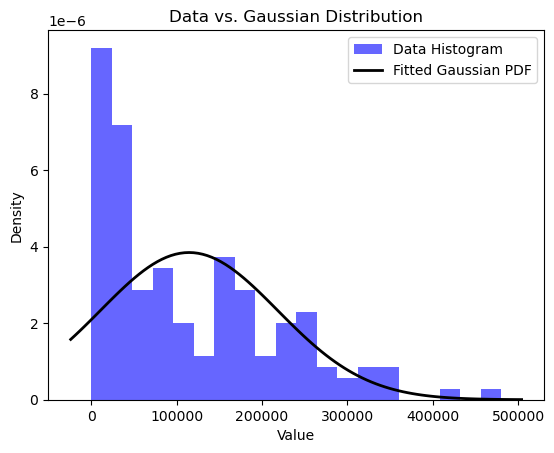

In [12]:
# Create a histogram of the data
plt.hist(df_ten, bins=20, density=True, alpha=0.6, color='b', label='Data Histogram')

# Fit a normal distribution to the data
from scipy.stats import norm

mu, std = norm.fit(df_ten)

# Create a PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Plot the PDF of the normal distribution
plt.plot(x, p, 'k', linewidth=2, label='Fitted Gaussian PDF')

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Data vs. Gaussian Distribution')
plt.show()

data is skewed so we fill its null values by its median

In [13]:
# Calculate the median of the 'Invoice_Amount' column while excluding 0 values
non_zero_values = df_ten[df_ten['Invoice_Amount'] != 0.0]['Invoice_Amount']
median_value = np.median(non_zero_values)

print(median_value)

87425.88


In [14]:
# Define a function to replace 0 values with the median
def replace_zero_with_median(value):
    if value == 0.0:
        return median_value
    else:
        return value
    
# Apply the function to the 'Invoice_Amount' column
df_ten['Invoice_Amount'] = df_ten['Invoice_Amount'].apply(replace_zero_with_median)

In [15]:
(df_ten['Invoice_Amount'] == 0).sum()

0

In [16]:
df_ten

,Invoice_Amount
Time_Stamp,
2019-09-04,18464.64
2019-09-14,36794.82
2019-09-24,19656.48
2019-10-04,576.00
2019-10-14,6018.16
...,...
2023-07-05,44111.70
2023-07-15,191624.79
2023-07-25,106142.73


In [17]:
df_ten.describe()

,Invoice_Amount
count,145.000000
mean,117011.474207
std,102401.624668
min,512.960000
25%,32969.120000
50%,87425.880000
75%,177226.740000
max,479969.280000


In [18]:
df_ten.to_csv('bluemountain.csv')

# Time Series Analysis on converted data, i.e. bluemountain.csv

In [19]:
df=pd.read_csv('bluemountain.csv')
df.head()

,Time_Stamp,Invoice_Amount
0,2019-09-04,18464.64
1,2019-09-14,36794.82
2,2019-09-24,19656.48
3,2019-10-04,576.00
4,2019-10-14,6018.16


In [20]:
df.set_index('Time_Stamp', inplace=True)

In [21]:
df.tail()

,Invoice_Amount
Time_Stamp,
2023-07-05,44111.70
2023-07-15,191624.79
2023-07-25,106142.73
2023-08-04,338511.09
2023-08-14,44929.85


In [22]:
df.index=pd.to_datetime(df.index)

In [23]:
df.index

DatetimeIndex(['2019-09-04', '2019-09-14', '2019-09-24', '2019-10-04',
               '2019-10-14', '2019-10-24', '2019-11-03', '2019-11-13',
               '2019-11-23', '2019-12-03',
               ...
               '2023-05-16', '2023-05-26', '2023-06-05', '2023-06-15',
               '2023-06-25', '2023-07-05', '2023-07-15', '2023-07-25',
               '2023-08-04', '2023-08-14'],
              dtype='datetime64[ns]', name='Time_Stamp', length=145, freq=None)

<Axes: title={'center': 'Blue Mountain Data'}, xlabel='Time_Stamp'>

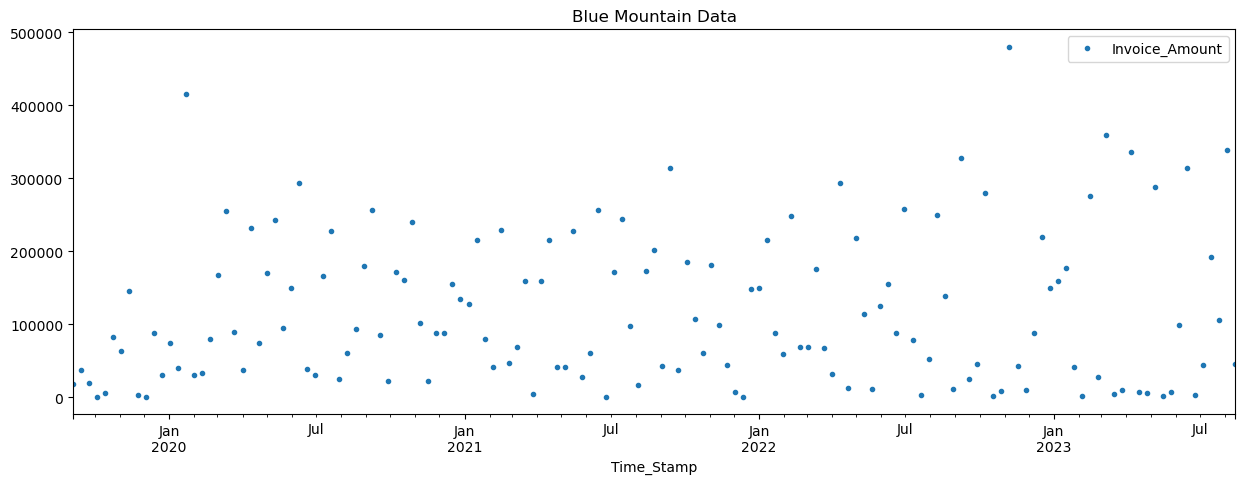

In [24]:
df.plot(style='.', figsize=(15,5), title='Blue Mountain Data')

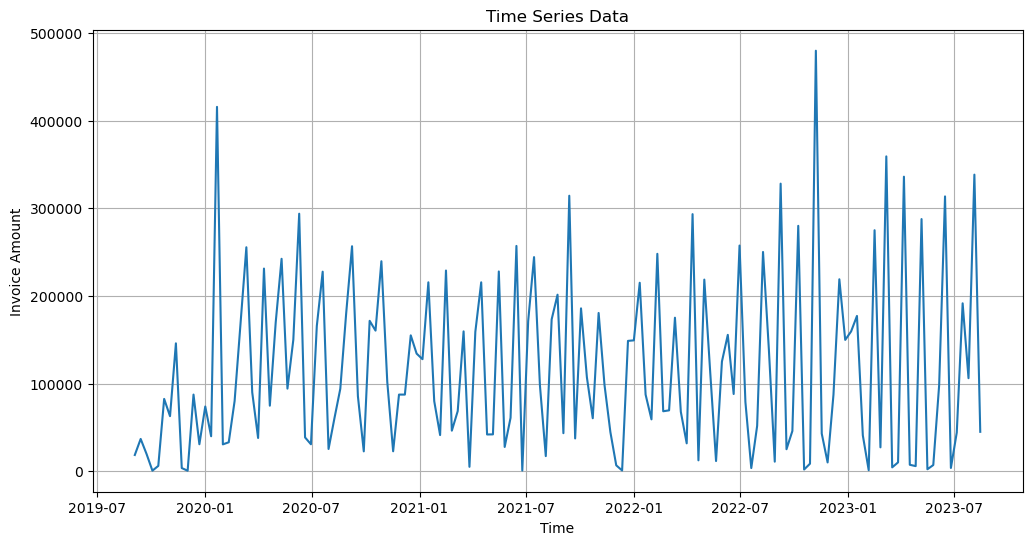

In [25]:
# Visualize the Time Series Data
plt.figure(figsize=(12, 6))
plt.plot(df['Invoice_Amount'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.grid()
plt.show()

The time series data graph you sent shows the average invoice amount for a company over the past 3 years.  The trend is slightly upward, indicating that the average invoice amount has been increasing over time.

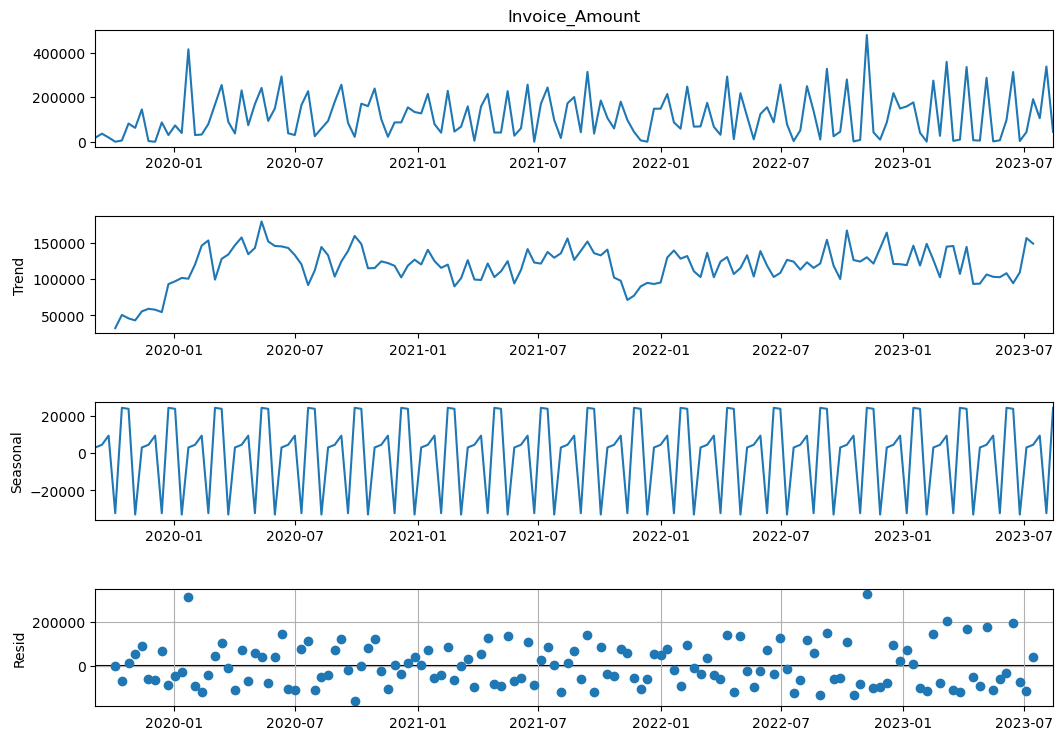

In [26]:
# Decomposition of the TS using the moving average decomposition 
decomposition = seasonal_decompose(df['Invoice_Amount'], model='additive')
fig=decomposition.plot();
fig.set_size_inches(12,8)
plt.grid()

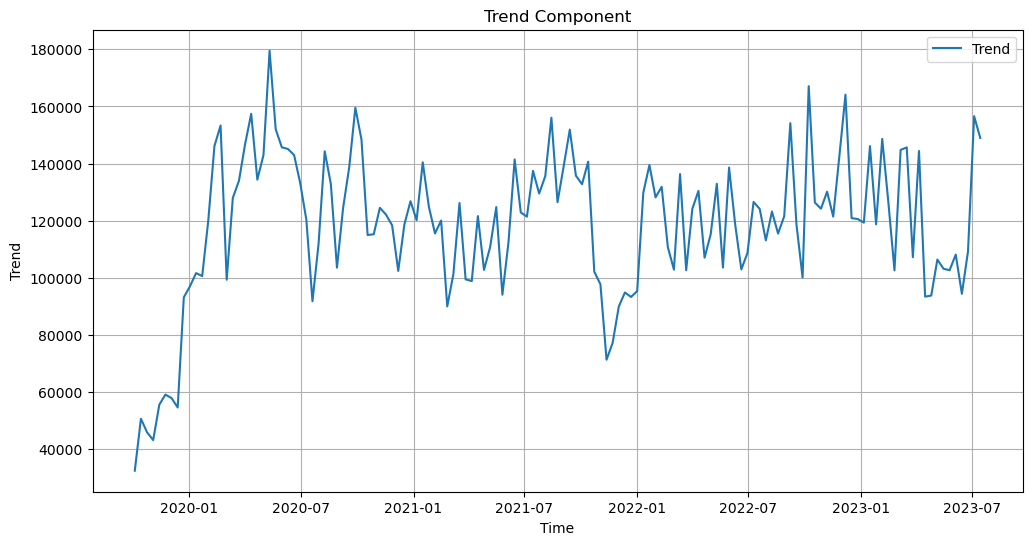

In [27]:
# Plot the Trend Component
plt.figure(figsize=(12, 6))
plt.plot(decomposition.trend, label='Trend')
plt.title('Trend Component')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.grid()
plt.legend()
plt.show()

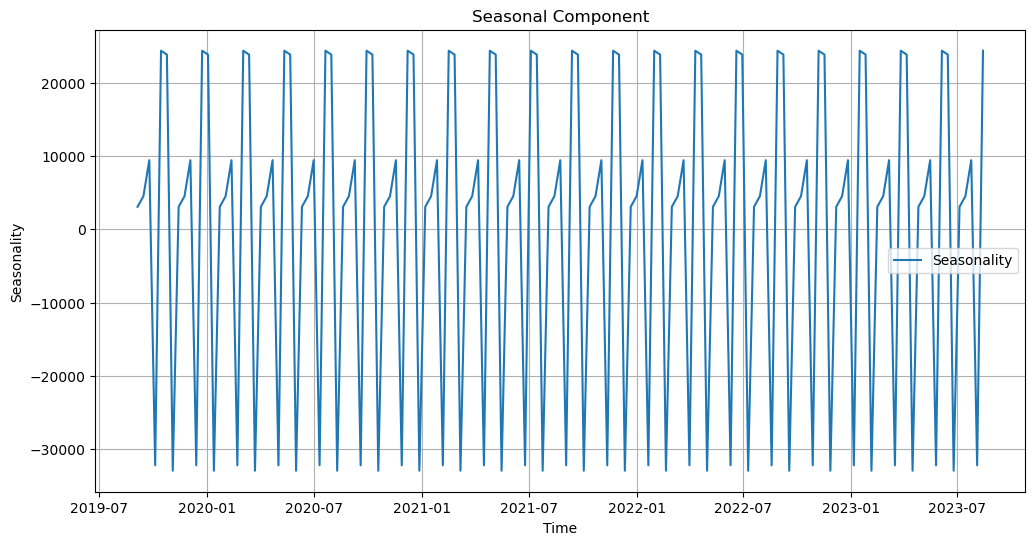

In [28]:
# Plot the Seasonal Component
plt.figure(figsize=(12, 6))
plt.plot(decomposition.seasonal, label='Seasonality')
plt.title('Seasonal Component')
plt.xlabel('Time')
plt.ylabel('Seasonality')
plt.grid()
plt.legend()
plt.show()

# Train/Test Split

In [29]:
# Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Forecasting Methods

## SARIMA

In [30]:
# SARIMA Model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 10))
sarima_model_fit = sarima_model.fit()

D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)


In [31]:
# Make Forecast with SARIMA
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test))
sarima_forecast_values = sarima_forecast.predicted_mean.values

In [32]:
# Calculate Accuracy Metrics for SARIMA
mae_sarima = mean_absolute_error(test, sarima_forecast_values)
mse_sarima = mean_squared_error(test, sarima_forecast_values)
rmse_sarima = np.sqrt(mse_sarima)
r2_sarima = r2_score(test, sarima_forecast_values)

## ARIMA

In [33]:
# ARIMA Model
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)


In [34]:
# Make Forecast with ARIMA
arima_forecast = arima_model_fit.forecast(steps=len(test))

In [35]:
# Calculate Accuracy Metrics for ARIMA
mae_arima = mean_absolute_error(test, arima_forecast)
mse_arima = mean_squared_error(test, arima_forecast)
rmse_arima = np.sqrt(mse_arima)
r2_arima = r2_score(test, arima_forecast)

## EXPONENTIAL SMOOTHING

In [36]:
# Exponential Smoothing Model
exp_smoothing_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=10)
exp_smoothing_model_fit = exp_smoothing_model.fit()

D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [37]:
# Make Forecast with Exponential Smoothing
exp_smoothing_forecast = exp_smoothing_model_fit.forecast(steps=len(test))

In [38]:
# Calculate Accuracy Metrics for Exponential Smoothing
mae_exp_smoothing = mean_absolute_error(test, exp_smoothing_forecast)
mse_exp_smoothing = mean_squared_error(test, exp_smoothing_forecast)
rmse_exp_smoothing = np.sqrt(mse_exp_smoothing)
r2_exp_smoothing = r2_score(test, exp_smoothing_forecast)

# Visualize Forecasts 

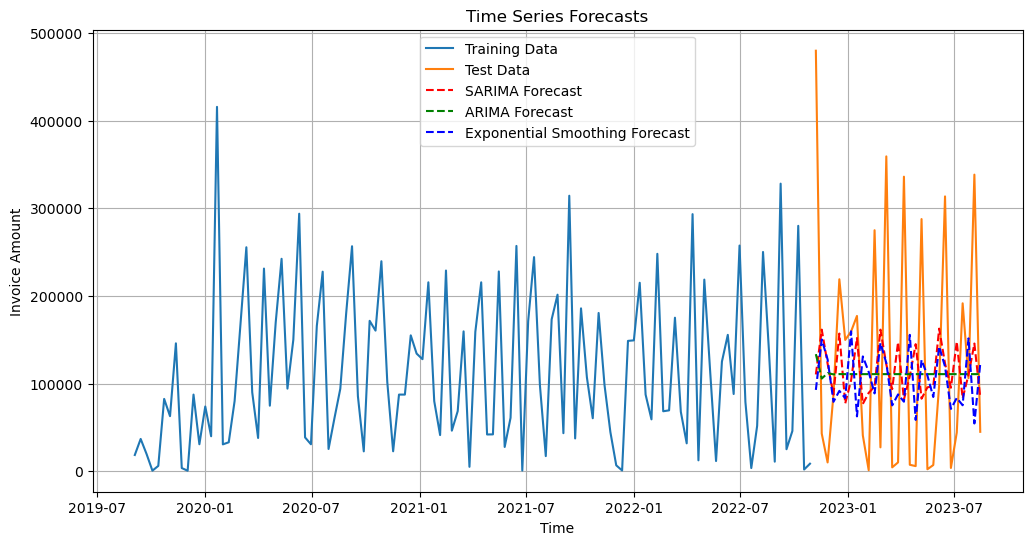

In [39]:
# Visualize Forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Test Data')
plt.plot(test.index, sarima_forecast_values, label='SARIMA Forecast', linestyle='--', color='red')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='green')
plt.plot(test.index, exp_smoothing_forecast, label='Exponential Smoothing Forecast', linestyle='--', color='blue')
plt.title('Time Series Forecasts')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.legend()
plt.grid()
plt.show()

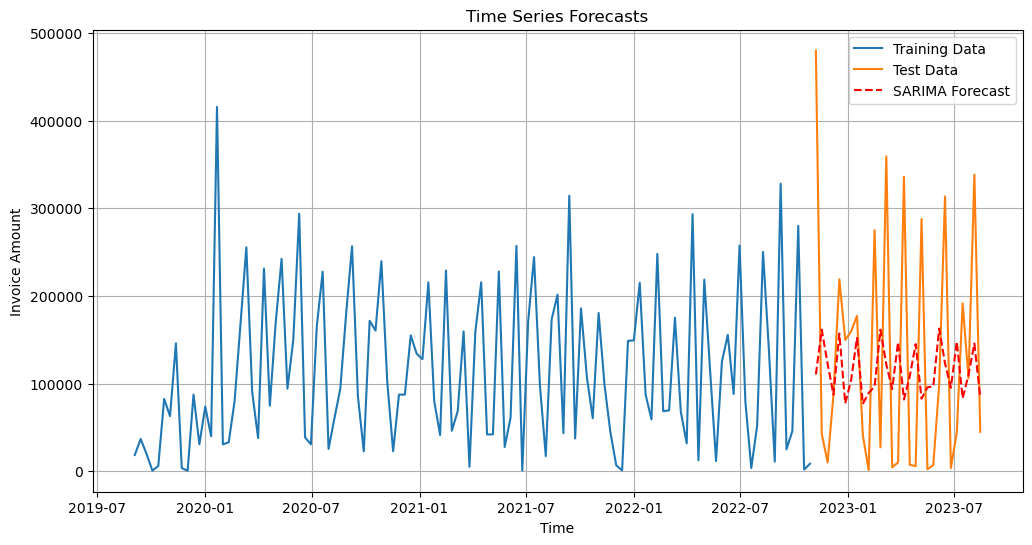

In [40]:
#SARIMA Visualize Forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Test Data')
plt.plot(test.index, sarima_forecast_values, label='SARIMA Forecast', linestyle='--', color='red')
plt.title('Time Series Forecasts')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.legend()
plt.grid()
plt.show()

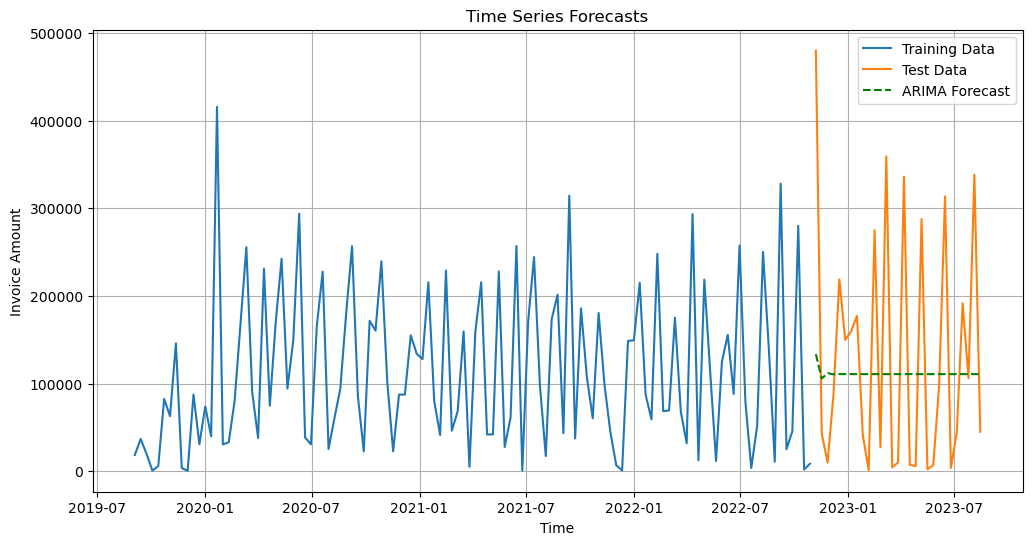

In [41]:
# Visualize ARIMA Forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Test Data')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='green')
plt.title('Time Series Forecasts')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.legend()
plt.grid()
plt.show()

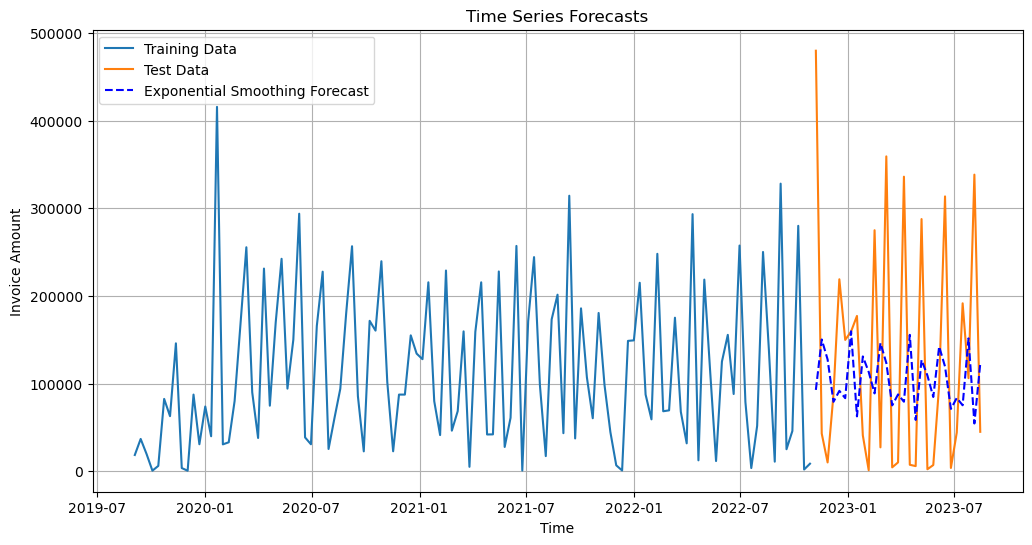

In [42]:
# Visualize ExponentialSmoothing Forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Test Data')
plt.plot(test.index, exp_smoothing_forecast, label='Exponential Smoothing Forecast', linestyle='--', color='blue')
plt.title('Time Series Forecasts')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.legend()
plt.grid()
plt.show()

# Print Accuracy Metrics for All Models

In [43]:
#SARIMA
print("SARIMA Metrics:")
print(f"Mean Absolute Error (MAE): {mae_sarima}")
print(f"Mean Squared Error (MSE): {mse_sarima}")
print(f"Root Mean Squared Error (RMSE): {rmse_sarima}")
print(f"R-squared (R2) Score: {r2_sarima}")

SARIMA Metrics:
Mean Absolute Error (MAE): 117096.21766363524
Mean Squared Error (MSE): 20061863867.482777
Root Mean Squared Error (RMSE): 141639.909162223
R-squared (R2) Score: -0.07932589041100857


In [44]:
#ARIMA
print("\nARIMA Metrics:")
print(f"Mean Absolute Error (MAE): {mae_arima}")
print(f"Mean Squared Error (MSE): {mse_arima}")
print(f"Root Mean Squared Error (RMSE): {rmse_arima}")
print(f"R-squared (R2) Score: {r2_arima}")


ARIMA Metrics:
Mean Absolute Error (MAE): 112804.57081597109
Mean Squared Error (MSE): 18463711238.046497
Root Mean Squared Error (RMSE): 135881.23946316686
R-squared (R2) Score: 0.006654531008102538


In [45]:
#Exponential Smoothing
print("\nExponential Smoothing Metrics:")
print(f"Mean Absolute Error (MAE): {mae_exp_smoothing}")
print(f"Mean Squared Error (MSE): {mse_exp_smoothing}")
print(f"Root Mean Squared Error (RMSE): {rmse_exp_smoothing}")
print(f"R-squared (R2) Score: {r2_exp_smoothing}")


Exponential Smoothing Metrics:
Mean Absolute Error (MAE): 120465.9840971902
Mean Squared Error (MSE): 21644063612.044445
Root Mean Squared Error (RMSE): 147119.215645151
R-squared (R2) Score: -0.16444804852090544


# Alternatively

In [46]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [47]:
# MA (Moving Average) models
ma_5 = train.rolling(window=5).mean().iloc[-1]
ma_15 = train.rolling(window=15).mean().iloc[-1]
ma_30 = train.rolling(window=30).mean().iloc[-1]

In [48]:
# ARIMA model
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_forecast = arima_model_fit.forecast(steps=len(test))

D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)


In [49]:
# SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=0)
sarima_forecast = sarima_model_fit.get_forecast(steps=len(test))
# Extract the predicted values from sarima_forecast
sarima_forecast_values = sarima_forecast.predicted_mean.values

D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)
D:\New folder\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10D will be used.
  self._init_dates(dates, freq)


In [50]:
# Calculate MAE and R-squared for each model
mae_ma_5 = mean_absolute_error(test, [ma_5] * len(test))
mae_ma_15 = mean_absolute_error(test, [ma_15] * len(test))
mae_ma_30 = mean_absolute_error(test, [ma_30] * len(test))
mae_arima = mean_absolute_error(test, arima_forecast)
mae_sarima = mean_absolute_error(test, sarima_forecast_values)

In [51]:
r2_ma_5 = r2_score(test, [ma_5] * len(test))
r2_ma_15 = r2_score(test, [ma_15] * len(test))
r2_ma_30 = r2_score(test, [ma_30] * len(test))
r2_arima = r2_score(test, arima_forecast)
r2_sarima = r2_score(test, sarima_forecast_values)

In [52]:
# Print MAE and R-squared for each model
print(f"MAE (MA-5): {mae_ma_5}, R-squared: {r2_ma_5}")
print(f"MAE (MA-15): {mae_ma_15}, R-squared: {r2_ma_15}")
print(f"MAE (MA-30): {mae_ma_30}, R-squared: {r2_ma_30}")
print(f"MAE (ARIMA): {mae_arima}, R-squared: {r2_arima}")
print(f"MAE (SARIMA): {mae_sarima}, R-squared: {r2_sarima}")

MAE (MA-5): 112273.56213793103, R-squared: -0.1924857371180102
MAE (MA-15): 114462.90885057472, R-squared: -0.01575619580476828
MAE (MA-30): 114877.11040229887, R-squared: -0.011642991255986335
MAE (ARIMA): 112804.57081597109, R-squared: 0.006654531008102538
MAE (SARIMA): 108943.45983363161, R-squared: 0.02873219892218748


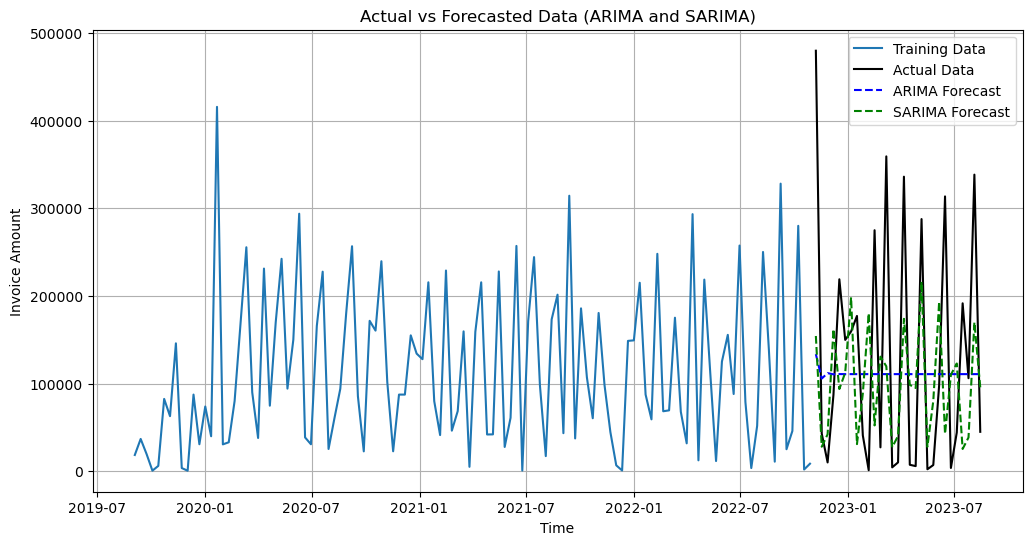

In [53]:
# Plot actual test data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Actual Data', color='black')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.plot(test.index, sarima_forecast_values, label='SARIMA Forecast', linestyle='--', color='green')
plt.legend()
plt.title('Actual vs Forecasted Data (ARIMA and SARIMA)')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.grid()
plt.show()

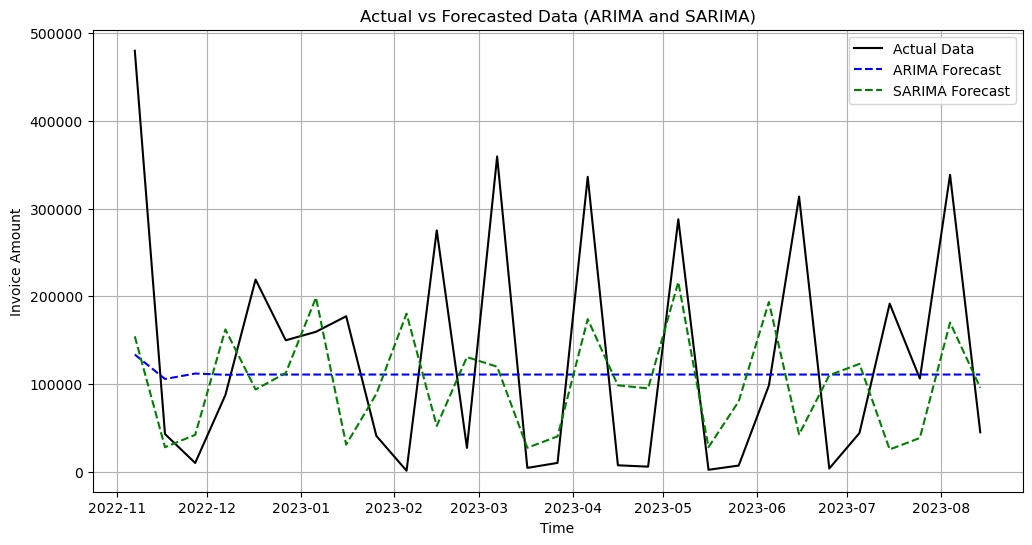

In [54]:
# Plot actual test data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Invoice_Amount'], label='Actual Data', color='black')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.plot(test.index, sarima_forecast_values, label='SARIMA Forecast', linestyle='--', color='green')
plt.legend()
plt.title('Actual vs Forecasted Data (ARIMA and SARIMA)')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.grid()
plt.show()

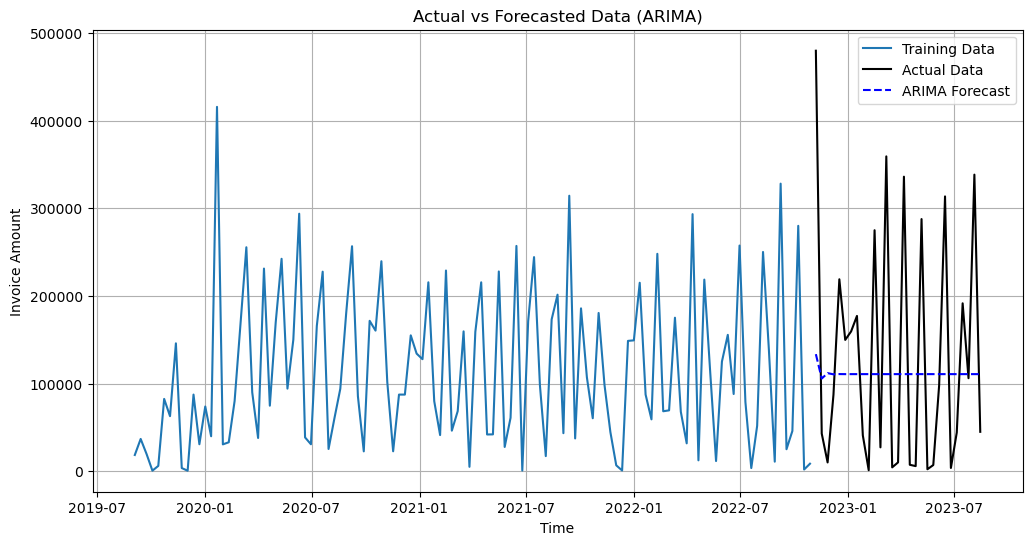

In [55]:
# Plot actual test data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Actual Data', color='black')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.legend()
plt.title('Actual vs Forecasted Data (ARIMA)')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.grid()
plt.show()

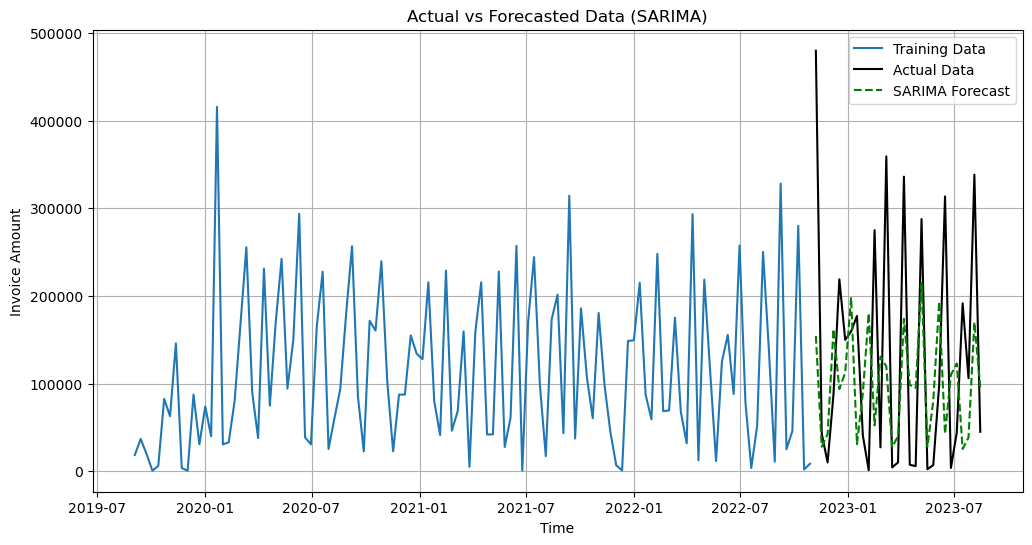

In [56]:
# Plot actual test data and forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Actual Data', color='black')
plt.plot(test.index, sarima_forecast_values, label='SARIMA Forecast', linestyle='--', color='green')
plt.legend()
plt.title('Actual vs Forecasted Data (SARIMA)')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.grid()
plt.show()

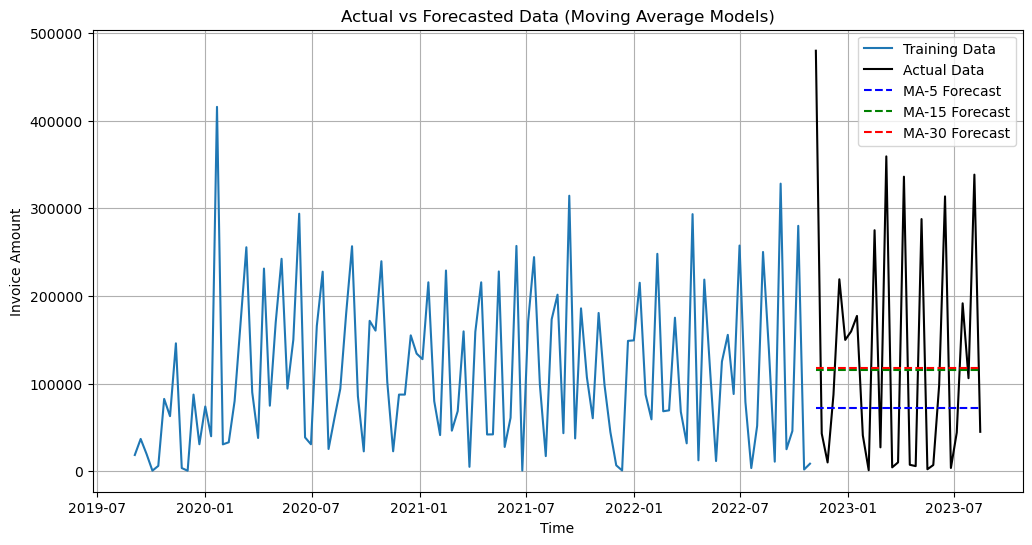

In [57]:
# MA models
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Invoice_Amount'], label='Training Data')
plt.plot(test.index, test['Invoice_Amount'], label='Actual Data', color='black')
plt.plot(test.index, [ma_5] * len(test), label='MA-5 Forecast', linestyle='--', color='blue')
plt.plot(test.index, [ma_15] * len(test), label='MA-15 Forecast', linestyle='--', color='green')
plt.plot(test.index, [ma_30] * len(test), label='MA-30 Forecast', linestyle='--', color='red')
plt.legend()
plt.title('Actual vs Forecasted Data (Moving Average Models)')
plt.xlabel('Time')
plt.ylabel('Invoice Amount')
plt.grid()
plt.show()